In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import re
from matplotlib.pyplot import figure
import warnings

warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

from_user = 0
to_user = 182
src_path = "C:/Users/12sha/Documents/thesislocation/Data/Final Example Results"

# fetch user vs train test months

usern_mnth_df = pd.read_csv("C:/Users/12sha/Documents/thesislocation/Data/user_vs_traintestmonth.csv", sep = "\t")
usern_mnth_df = usern_mnth_df.drop(['Unnamed: 0'], axis=1)

In [ ]:
# True positives, true negatives, false positives, false negatives, accuracy

# Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):
    R = 6378.137  # Radius of earth in KM
    dlat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dlon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(lat1 * math.pi / 180) * math.cos(
        lat2 * math.pi / 180) * math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d * 1000  # meters


def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    plt.xticks(range(3))
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)


# calculate prediction parameters
def check_pred(indx_row):
    global predic_df
    global tobepredicted_df
    global correct_pred
    global incorrect_pred
    global true_pos
    global false_pos
    global true_neg
    global false_neg

    true_pred = False
    visit_next_hour = False
    visit_count_next_hour = 0
    curr_hour = tobepredicted_df.loc[indx_row, 'Hour']
    curr_date = tobepredicted_df.loc[indx_row, 'Date']

    # check if there are points found in next hour
    for k in range(indx_row + 1, len(tobepredicted_df)):

        next_hour = tobepredicted_df.loc[k, 'Hour']
        next_date = tobepredicted_df.loc[k, 'Date']

        if (curr_hour != next_hour) or (curr_date != next_date):

            if (curr_hour == 23) and (next_date == curr_date + timedelta(days=1)) and (next_hour == 0):
                visit_next_hour = True
                visit_count_next_hour = visit_count_next_hour + 1
            elif (next_date == curr_date) and (next_hour == curr_hour + 1):
                visit_next_hour = True
                visit_count_next_hour = visit_count_next_hour + 1
            else:
                break

    # visit encountered in next hour: Either:
    #      A. True Positive, or
    #      B. False Negative
    if visit_next_hour == True:

        # B. False Negative
        if predic_df.empty:
            false_neg = false_neg + 1
        # A. True Positive
        else:
            true_pos = true_pos + 1

            # check if prediction is correct or incorrect
            for l in range(1, visit_count_next_hour + 1):

                true_lat = tobepredicted_df['AvgLat'][indx_row + l]
                true_lon = tobepredicted_df['AvgLon'][indx_row + l]
                true_pred = False
                for i in range(0, len(predic_df)):

                    pred_lat = predic_df.loc[i, 'Latitude']
                    pred_lon = predic_df.loc[i, 'Longitude']

                    if meters(true_lat, true_lon, pred_lat, pred_lon) <= state_d_thrhld:
                        correct_pred = correct_pred + 1
                        true_pred = True
                        break

                if true_pred == True:
                    break

            if true_pred == False:
                incorrect_pred = incorrect_pred + 1

    # visit not encountered in next hour: Either:
    #      A. False Positive, or
    #      B. True Negative
    else:
        # B. True Negative
        if predic_df.empty:
            true_neg = true_neg + 1
        # A. False Positive
        else:
            false_pos = false_pos + 1


def predict():
    global trained_model_df
    global hourlyweights_df
    global tobepredicted_df
    global predic_df
    global total_pred
    global correct_pred
    global incorrect_pred
    global true_pos
    global false_pos
    global true_neg
    global false_neg
    
    # if the training model or the hourly state weight file is empty, return
    if hourlyweights_df.empty or trained_model_df.empty:
        return
    
    # flag to track if the prediction is made or not
    pred_made = False

    # create a list for all the states, latitude, longitude, date, hour for which the prediction should be done
    row = 0
    for i in range(0, len(hourlyweights_df)):
        for j in range(0, 24):
            if hourlyweights_df.loc[i, str(j)] != 0:
                tobepredicted_df.loc[row, 'Date'] = hourlyweights_df.loc[i, 'Date']
                tobepredicted_df.loc[row, 'StateId'] = hourlyweights_df.loc[i, 'StateId']
                tobepredicted_df.loc[row, 'AvgLat'] = hourlyweights_df.loc[i, 'AvgLat']
                tobepredicted_df.loc[row, 'AvgLon'] = hourlyweights_df.loc[i, 'AvgLon']
                tobepredicted_df.loc[row, 'Hour'] = j
                row = row + 1
    tobepredicted_df['Date'] = pd.to_datetime(tobepredicted_df['Date'])
    tobepredicted_df = tobepredicted_df.sort_values(['Date', 'Hour'])
    tobepredicted_df = tobepredicted_df.reset_index(drop=True)

    # create prediction file path
    file_name = "Predictions.csv"
    file = dest_predicted_dir + file_name
    # remove if the file already exists
    try:
        os.remove(file)
    except OSError:
        pass

    # start reading to be predicted list and predict
    for j in range(0, len(tobepredicted_df)):

        new_lat = tobepredicted_df['AvgLat'][j]
        new_lon = tobepredicted_df['AvgLon'][j]
        hour = tobepredicted_df.loc[j, 'Hour']

        for i in range(0, len(trained_model_df)):

            trn_lat = trained_model_df['AvgLat'][i]
            trn_lon = trained_model_df['AvgLon'][i]
            predic_df = pd.DataFrame()
            pred_made = False

            if meters(trn_lat, trn_lon, new_lat, new_lon) <= state_d_thrhld:
                # prediction is made
                pred_made = True
                total_pred = total_pred + 1

                cluster_id = trained_model_df['StateId'][i]

                jmp_dat = False
                if hour == 23:
                    jmp_dat = True

                if jmp_dat == True:
                    # check if there exists a next row
                    if i + 1 < len(trained_model_df):
                        from_col_no = 5
                        to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                        predic_df = trained_model_df.iloc[i + 1:i + 2, int(from_col_no):int(to_col_no)]
                    else:
                        break
                else:
                    from_col_no = trained_model_df['StateId'].nunique() * (hour + 1) + 5
                    to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                    predic_df = trained_model_df.iloc[i:i + 1, int(from_col_no):int(to_col_no)]

                predic_df = predic_df.T
                predic_df['StateId'] = cluster_id
                predic_df['PredState'] = predic_df.index
                predic_df['PredState'] = predic_df['PredState'].map(lambda x: x.split('-', 2)[-1])
                predic_df.columns = ['Probability', 'StateId', 'PredState']

                predic_df = predic_df.sort_values('Probability', ascending=False)
                predic_df['DateHour'] = str(tobepredicted_df['Date'][j]) + " " + str(tobepredicted_df['Hour'][j])
                predic_df['Address'] = 0
                predic_df['Latitude'] = 0.0
                predic_df['Longitude'] = 0.0
                predic_df = predic_df.reset_index(drop=True)

                for k in range(0, len(predic_df)):
                    clus_to_find = int(float(predic_df['PredState'][k]))
                    add = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'Address'].values[0]
                    lat = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'AvgLat'].values[0]
                    lon = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'AvgLon'].values[0]

                    predic_df.loc[k, 'Address'] = add
                    predic_df.loc[k, 'Latitude'] = lat
                    predic_df.loc[k, 'Longitude'] = lon

                predic_df.to_csv(file, mode='a')
                break

        # if prediction was made, calculate prediction parameters
        if pred_made == True:
            check_pred(j)

    # plot parameters
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    objects = ('Tot Pred', 'Corr Pred', 'Incor Pred', 'True Pos', 'False Pos', 'False Neg', 'True Neg')
    y_pos = np.arange(len(objects))
    performance = [total_pred, correct_pred, incorrect_pred, true_pos, false_pos, false_neg, true_neg]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Count')
    plt.title(user + 'Prediction Performance')
    destpng = dest_predicted_dir + "pred performance.png"
    plt.savefig(destpng)
    plt.show()

    # prediction parameters
    if total_pred != 0:
        acc = correct_pred / total_pred * 100
    else:
        acc = 0

    if (true_pos + false_neg) != 0:
        true_pos_rate = true_pos / (true_pos + false_neg) * 100
    else:
        true_pos_rate = 0

    if total_pred != 0:
        acc_pos = (true_pos + true_neg) / total_pred * 100
    else:
        acc_pos = 0

    if (true_pos + false_pos) != 0:
        pos_pred_value = true_pos / (true_pos + false_pos) * 100
        false_dis_rate = false_pos / (true_pos + false_pos) * 100
    else:
        pos_pred_value = 0
        false_dis_rate = 0

    prediction_perf = ("Total Predictions: " + str(total_pred) + "\nCorrect Predictions: " + str(correct_pred) +
                       "\nIncorrect Predictions: " + str(incorrect_pred) +
                       "\nAccuracy%: " + str(acc) +
                       "\nTrue Positives: " + str(true_pos) + "\nFalse Positives: " + str(false_pos) +
                       "\nFalse Negatives: " + str(false_neg) + "\nTrue Negatives: " + str(true_neg) +
                       "\nTrue positive rate(Recall)%: " + str(true_pos_rate) +
                       # "\nFalse positive rate(Fall-out): " + str(false_pos_rate) +
                       "\nAccuracy Positives%: " + str(acc_pos) +
                       "\nPositive predictive value(Precision)%: " + str(pos_pred_value) +
                       "\nFalse discovery rate%: " + str(false_dis_rate))
    text_file = dest_predicted_dir + "corr pred ratio " + str(acc) + " .txt"
    
    # delete the file if already present
    for f in os.listdir(dest_predicted_dir):
        if re.search("corr pred ratio ", f):
            os.remove(os.path.join(dest_predicted_dir, f))
            
    # write the new file        
    f = open(text_file, "w+")
    f.write(prediction_perf)
    f.close()

# -----------------------------------------------------------------------------------------
state_d_thrhld = 200
acc_per = []
err_per = []

for i in range(from_user, to_user):
    user = "{0:0=3d}".format(usern_mnth_df.loc[i, 'User'])
    train_month = str(usern_mnth_df.loc[i, 'TrainMonth'])
    test_month = str(usern_mnth_df.loc[i, 'TestMonth'])

    tobepredicted_df = pd.DataFrame()
    predic_df = pd.DataFrame()

    # hourly weight file path
    hourlyweights_file = src_path + "/User " + user + "/" + test_month + "/hourlyweights/hourlyweights.csv"
    # trained model
    trained_model_file = src_path + "/User " + user + "/" + train_month + "/markovchains/final.csv"
    # predicted file
    dest_predicted_dir = src_path + "/User " + user + "/" + test_month + "/predict/"

    # counts
    total_pred = 0
    correct_pred = 0
    incorrect_pred = 0
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0

    # check if the path is found
    if ((not os.path.exists(src_path + "/User " + user + "/" + test_month)) or
            not os.path.exists(src_path + "/User " + user + "/" + train_month)):
        print("For user: " + user + " test and training path not found." +
              " Check if you have files inside: <<" + src_path + "/User " + user + "/" + test_month + "/hourlyweights/hourlyweights.csv"
                                                                                                      ">> and <<" + src_path + "/User " + user + "/" + train_month + "/markovchains/final.csv>>")
        continue

    # check if the file is found
    if ((not os.path.isfile(trained_model_file)) or
            (not os.path.isfile(hourlyweights_file))):
        print("For user: " + user + " test and training files not found.")
        continue

    trained_model_df = pd.read_csv(trained_model_file, header=0)
    hourlyweights_df = pd.read_csv(hourlyweights_file, header=0, sep='\t')

    predict()

    if total_pred != 0:
        acc_per_v = correct_pred / total_pred
        err_per_v = incorrect_pred / total_pred
        acc_per.append(acc_per_v)
        err_per.append(err_per_v)

print("mean accuracy percentage: " + str(sum(acc_per) / len(acc_per), 2))
print("mean error percentage: " + str(sum(err_per) / len(err_per)))

# plot error percentage
fig, ax = plt.subplots()
draw_plot(err_per, "tomato", "white")
plt.title("Error Percentage with median: " + str(round(np.median(err_per),2)))

# plot accuracy percentage
fig, ax = plt.subplots()
draw_plot(acc_per, "tomato", "white")
plt.title("Accuracy Percentage with median: " + str(round(np.median(acc_per),2)))

User: 000. Cosine Similarity is: 0.7441054926788429
User: 000. Accuracy Correctness is: 0.8223270440251572
User: 000. Accuracy Precision is: 0.6398882235823254
User: 001. Cosine Similarity is: 0.8383847717449147
User: 001. Accuracy Correctness is: 0.8823529411764706
User: 001. Accuracy Precision is: 0.7629533835314478
User: 002. Cosine Similarity is: 0.9127305936676772
User: 002. Accuracy Correctness is: 0.9388379204892966
User: 002. Accuracy Precision is: 0.8146658581901199
User: 003. Cosine Similarity is: 0.703296412253689
User: 003. Accuracy Correctness is: 0.8566176470588235
User: 003. Accuracy Precision is: 0.5964649988185924
User: 004. Cosine Similarity is: 0.699513442541384
User: 004. Accuracy Correctness is: 0.8038067349926794
User: 004. Accuracy Precision is: 0.6048010933306601
User: 005. Cosine Similarity is: 0.843894579366166
User: 005. Accuracy Correctness is: 0.8947368421052632
User: 005. Accuracy Precision is: 0.7426784959328948
User: 006. Cosine Similarity is: 0.56474990

User: 055. Cosine Similarity is: 0.8226622064893708
User: 055. Accuracy Correctness is: 0.9848484848484849
User: 055. Accuracy Precision is: 0.7135914353086226
User: 057. Cosine Similarity is: 0.9850712500068213
User: 057. Accuracy Correctness is: 1.0
User: 057. Accuracy Precision is: 0.7666408900769791
For user: 060 test and training path not found. Check if you have files inside: <<C:/Users/12sha/Documents/thesislocation/Data/Final Example Results/User 060/na/staypoints/staypoints.csv>> and <<C:/Users/12sha/Documents/thesislocation/Data/Final Example Results/User 060/200708/markovchains/final.csv>>
User: 062. Cosine Similarity is: 0.30393445808694136
User: 062. Accuracy Correctness is: 0.8181818181818182
User: 062. Accuracy Precision is: 0.3132537551009624
For user: 064 test and training path not found. Check if you have files inside: <<C:/Users/12sha/Documents/thesislocation/Data/Final Example Results/User 064/na/staypoints/staypoints.csv>> and <<C:/Users/12sha/Documents/thesislocat

User: 119. Cosine Similarity is: 0.802793781048606
User: 119. Accuracy Correctness is: 0.95
User: 119. Accuracy Precision is: 0.6449252521751989
For user: 120 test and training path not found. Check if you have files inside: <<C:/Users/12sha/Documents/thesislocation/Data/Final Example Results/User 120/na/staypoints/staypoints.csv>> and <<C:/Users/12sha/Documents/thesislocation/Data/Final Example Results/User 120/200909/markovchains/final.csv>>
For user: 121 test and training path not found. Check if you have files inside: <<C:/Users/12sha/Documents/thesislocation/Data/Final Example Results/User 121/na/staypoints/staypoints.csv>> and <<C:/Users/12sha/Documents/thesislocation/Data/Final Example Results/User 121/200910/markovchains/final.csv>>
For user: 123 test and training path not found. Check if you have files inside: <<C:/Users/12sha/Documents/thesislocation/Data/Final Example Results/User 123/na/staypoints/staypoints.csv>> and <<C:/Users/12sha/Documents/thesislocation/Data/Final Exa

User: 174. Cosine Similarity is: 0.5257834230173754
User: 174. Accuracy Correctness is: 1.0
User: 174. Accuracy Precision is: 0.4010522250754264
For user: 175 test and training path not found. Check if you have files inside: <<C:/Users/12sha/Documents/thesislocation/Data/Final Example Results/User 175/na/staypoints/staypoints.csv>> and <<C:/Users/12sha/Documents/thesislocation/Data/Final Example Results/User 175/200710/markovchains/final.csv>>
For user: 177 test and training path not found. Check if you have files inside: <<C:/Users/12sha/Documents/thesislocation/Data/Final Example Results/User 177/na/staypoints/staypoints.csv>> and <<C:/Users/12sha/Documents/thesislocation/Data/Final Example Results/User 177/200909/markovchains/final.csv>>
For user: 178 test and training path not found. Check if you have files inside: <<C:/Users/12sha/Documents/thesislocation/Data/Final Example Results/User 178/na/staypoints/staypoints.csv>> and <<C:/Users/12sha/Documents/thesislocation/Data/Final Exa

Text(0,0.5,'Result')

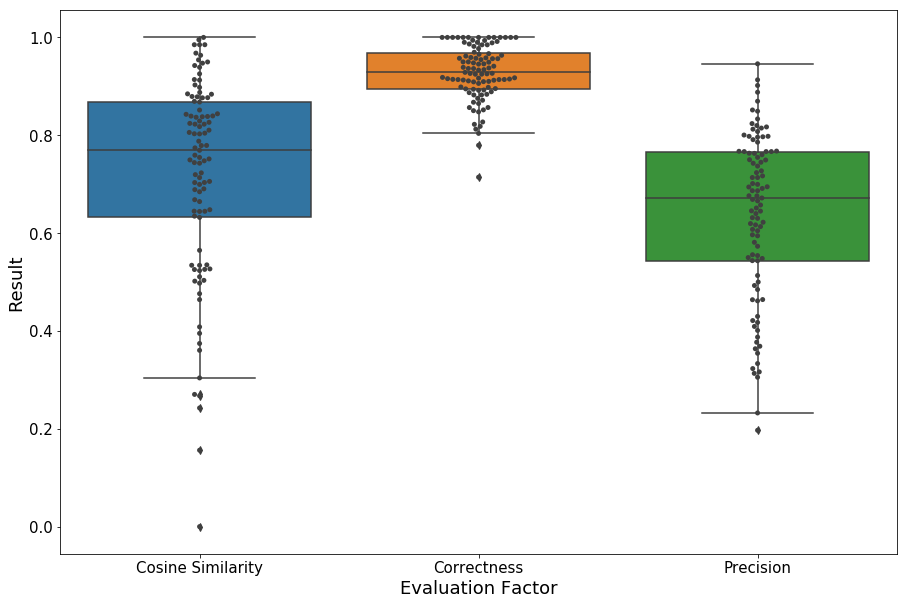

In [41]:
# cosine similarity

from scipy import spatial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import re
import warnings

warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

from_user = 0
to_user = 182
src_path = "C:/Users/12sha/Documents/thesislocation/Data/Final Example Results"

# fetch user vs train test months

usern_mnth_df = pd.read_csv("C:/Users/12sha/Documents/thesislocation/Data/user_vs_traintestmonth.csv", sep="\t")
usern_mnth_df = usern_mnth_df.drop(['Unnamed: 0'], axis=1)


# Cosine Similarity

# Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):
    R = 6378.137  # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat / 2) * math.sin(dLat / 2) + math.cos(lat1 * math.pi / 180) * math.cos(
        lat2 * math.pi / 180) * math.sin(dLon / 2) * math.sin(dLon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d * 1000  # meters


def extend_array(l, n):
    l.extend([0] * n)
    l = l[:n]
    return l


def dotproduct(v1, v2):
    return sum((a * b) for a, b in zip(v1, v2))


def length(v):
    return math.sqrt(dotproduct(v, v))


# def find_similarity(pred_prob, act_prob_all):
#    return math.acos(dotproduct(pred_prob, act_prob_all) / (length(pred_prob) * length(act_prob_all)))

def find_similarity(pred_prob, act_prob_all):
    result = 1 - spatial.distance.cosine(pred_prob, act_prob_all)
    return result


def total_variation_distance(pred_prob, act_prob_all):
    diff_sum = 0
    for i in range(0, len(pred_prob)):
        diff_sum = diff_sum + abs(pred_prob[i] - act_prob_all[i])
    diff_sum = diff_sum/2
    return diff_sum


def accuracy(pred_prob, act_prob_all):
    acc = False
    if sum(pred_prob)!=0:
        # find the max in predicted list
        max_pred = max(pred_prob)
        max_pred_pos = [i for i, j in enumerate(pred_prob) if j == max_pred]

        # find max in ground truth list
        max_truth = max(act_prob_all)
        max_truth_pos = [i for i, j in enumerate(act_prob_all) if j == max_truth]

        # check if max prediction list and max ground truth list matches
        acc = not set(max_pred_pos).isdisjoint(max_truth_pos)
    return acc


# calculate prediction parameters
def check_pred(hour, indx_row):
    global predic_df
    global hrywghts_df
    global similarity_arr
    global precision_arr
    global correct_arr

    pred_prob = predic_df['PredProbability'].values
    act_prob_all = [0] * len(pred_prob)
    curr_date = hrywghts_df.loc[indx_row, 'Date']

    jmp_dat = False
    if hour == 23:
        jmp_dat = True

    # check if there are GPS coordinates found in next hour
    # the next hour is checked for the entire day, and all the visits in the next hour are recorded
    hrywghts_day_df = hrywghts_df.loc[hrywghts_df['Date'] == curr_date]
    hrywghts_day_df = hrywghts_day_df.reset_index(drop=True)
    for k in range(0, len(hrywghts_day_df)):
        if jmp_dat == True:
            if k + 1 < len(hrywghts_day_df):
                next_hour = 0
                row = k + 1
            else:
                break
        else:
            next_hour = hour + 1
            row = k

        if hrywghts_day_df.loc[row, str(next_hour)] != 0:

            true_lat = hrywghts_day_df['AvgLat'][row]
            true_lon = hrywghts_day_df['AvgLon'][row]

            # look for the next visited GPS coordinate in the predicted vector
            for i in range(0, len(predic_df)):
                pred_lat = predic_df.loc[i, 'Latitude']
                pred_lon = predic_df.loc[i, 'Longitude']

                if meters(true_lat, true_lon, pred_lat, pred_lon) <= state_d_thrhld:
                    act_prob_all[i] = hrywghts_day_df.loc[k, str(next_hour)]
                    break

    #   Use the below code if the method "find_similarity" used as to find the cosine degree
    #     #if the actual_prob_all has all 0's, this means the prediction is incorrect and hence similarity is 0.
    #     if np.mean(act_prob_all) == 0:
    #         similarity = 90
    #     else:
    #         similarity = find_similarity(pred_prob, act_prob_all)
    # Find cosine similarity between actual probability and predicted probability vectors
    similarity = find_similarity(pred_prob, act_prob_all)
    similarity_arr = np.append(similarity_arr, similarity)
    predic_df['ActProbability'] = act_prob_all
    predic_df['Similarity'] = similarity

    # accuracy
    acc = accuracy(pred_prob, act_prob_all)
    correct_arr = np.append(correct_arr, acc)

    # total variation distance
    tot_var_dis = total_variation_distance(pred_prob, act_prob_all)
    precision_arr = np.append(precision_arr, 1-tot_var_dis)


def predict():
    global trained_model_df
    global hrywghts_df
    global predic_df

    file_name = "Similarity.csv"
    file = dest_predicted_dir + file_name

    # remove if the file already exists
    try:
        os.remove(file)
    except OSError:
        pass

    # read user movements for each time slot
    for j in range(0, len(hrywghts_df)):
        for h in range(0, 24):
            # continue only if the data is non-zero
            if hrywghts_df.loc[j, str(h)] != 0:
                hour = h
                new_lat = hrywghts_df['AvgLat'][j]
                new_lon = hrywghts_df['AvgLon'][j]
                # current state probabilities
                curr_state_prob = hrywghts_df.loc[j, str(h)]

                # search the coordinate in markov model
                for i in range(0, len(trained_model_df)):

                    trn_lat = trained_model_df['AvgLat'][i]
                    trn_lon = trained_model_df['AvgLon'][i]
                    predic_df = pd.DataFrame()

                    if meters(trn_lat, trn_lon, new_lat, new_lon) <= state_d_thrhld:

                        cluster_id = trained_model_df['StateId'][i]

                        # next hour prediction probabilities
                        jmp_dat = False
                        if hour == 23:
                            jmp_dat = True

                        if jmp_dat == True:
                            # check if there exists a next row
                            if i + 1 < len(trained_model_df):
                                from_col_no = 5
                                to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                                predic_df = trained_model_df.iloc[i + 1:i + 2, from_col_no:to_col_no]
                            else:
                                break
                        else:
                            from_col_no = trained_model_df['StateId'].nunique() * (hour + 1) + 5
                            to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                            predic_df = trained_model_df.iloc[i:i + 1, from_col_no:to_col_no]

                        predic_df = (predic_df).T

                        predic_df['StateId'] = cluster_id
                        predic_df['PredState'] = predic_df.index
                        predic_df['PredState'] = predic_df['PredState'].map(lambda x: x.split('-', 2)[-1])

                        predic_df.columns = ['PredProbability', 'StateId', 'PredState']

                        # predic_df = predic_df.sort_values('Probability', ascending=False).head(10)
                        predic_df = predic_df.sort_values('PredProbability', ascending=False)
                        predic_df['DateHour'] = str(hrywghts_df['Date'][j]) + " " + str(hour)
                        predic_df['Address'] = 0
                        predic_df['Latitude'] = 0.0
                        predic_df['Longitude'] = 0.0
                        predic_df = predic_df.reset_index(drop=True)

                        for k in range(0, len(predic_df)):
                            # import pdb; pdb.set_trace()
                            clus_to_find = int(float(predic_df['PredState'][k]))
                            add = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'Address'].values[
                                0]
                            lat = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'AvgLat'].values[
                                0]
                            lon = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'AvgLon'].values[
                                0]

                            predic_df.loc[k, 'Address'] = add
                            predic_df.loc[k, 'Latitude'] = lat
                            predic_df.loc[k, 'Longitude'] = lon

                        # if prediction was made, calculate prediction parameters
                        check_pred(hour, j)

                        predic_df.to_csv(file, mode='a')
                        break


# --------------------------------------- MAIN ----------------------------------------------------------------
state_d_thrhld = 200
cos_sim_mean = []
cor_mean = []
pre_mean = []

for i in range(from_user, to_user):

    user = "{0:0=3d}".format(usern_mnth_df.loc[i, 'User'])
    train_month = str(usern_mnth_df.loc[i, 'TrainMonth'])
    test_month = str(usern_mnth_df.loc[i, 'TestMonth'])

    tobepredicted_df = pd.DataFrame()
    predic_df = pd.DataFrame()

    # hourly weights file
    hrly_wghts_file = src_path + "/User " + user + "/" + test_month + "/hourlyweights/hourlyweights.csv"
    # trained model
    trained_model_file = src_path + "/User " + user + "/" + train_month + "/markovchains/final.csv"
    # predicted file
    dest_predicted_dir = src_path + "/User " + user + "/" + test_month + "/predict/"

    similarity_arr = []
    precision_arr = []
    correct_arr = []

    # check if the path is found
    if ((not os.path.exists(src_path + "/User " + user + "/" + test_month)) or
            not os.path.exists(src_path + "/User " + user + "/" + train_month)):
        print("For user: " + user + " test and training path not found." +
              " Check if you have files inside: <<" + src_path + "/User " + user + "/" + test_month + "/staypoints/staypoints.csv"
                                                                                                      ">> and <<" + src_path + "/User " + user + "/" + train_month + "/markovchains/final.csv>>")
        continue

    # check if the file is found
    if ((not os.path.isfile(trained_model_file)) or
            (not os.path.isfile(hrly_wghts_file))):
        print("For user: " + user + " test and training files not found.")
        continue

    trained_model_df = pd.read_csv(trained_model_file, header=0)
    hrywghts_df = pd.read_csv(hrly_wghts_file, header=0, sep='\t')

    # start the prediction
    predict()

    # delete the file if already present
    for f in os.listdir(dest_predicted_dir):
        if re.search("Similarity mean ", f):
            os.remove(os.path.join(dest_predicted_dir, f))

    # save similarity mean in a text file for each user
    if len(similarity_arr) != 0:
        similarity_arr = similarity_arr[np.logical_not(np.isnan(similarity_arr))]
        sim_mean = np.mean(similarity_arr)
        text_file = dest_predicted_dir + "Similarity mean " + str(sim_mean) + " .txt"
        f = open(text_file, "w+")
        f.close()
        print("User: " + user + ". Cosine Similarity is: " + str(sim_mean))
        cos_sim_mean.append(sim_mean)

    # calculate mean of accuracy and distance variation for each user
    if len(correct_arr) != 0:
        print("User: " + user + ". Accuracy Correctness is: " + str(np.mean(correct_arr)))
        cor_mean.append(np.mean(correct_arr))
    if len(precision_arr) != 0:
        print("User: " + user + ". Accuracy Precision is: " + str(np.mean(precision_arr)))
        pre_mean.append(np.mean(precision_arr))

if len(cos_sim_mean) != 0:
    cos_sim_mean = [x for x in cos_sim_mean if str(x) != 'nan']
    print("mean cosine similarity: " + str(sum(cos_sim_mean) / len(cos_sim_mean)))

if len(cor_mean) != 0:
    print("mean accuracy (correctness): " + str(sum(cor_mean) / len(cor_mean)))

if len(pre_mean) != 0:
    print("mean accuracy (preciosn): " + str(sum(pre_mean) / len(pre_mean)))

# create box-plots for all the metric data

# if the ararys are not of same lengths, change the size by adding zeros
if (len(cos_sim_mean) != len(cor_mean) or 
    len(cos_sim_mean) != (pre_mean) or
   len(cor_mean) != (pre_mean)):
    max_n = max(len(cos_sim_mean), len(cor_mean), len(pre_mean))
    cos_sim_mean.extend([0]* (max_n-len(cos_sim_mean)))
    cor_mean.extend([0]* (max_n-len(cor_mean)))
    pre_mean.extend([0]* (max_n-len(pre_mean)))
    
summ_df= pd.DataFrame({'Cosine Similarity': cos_sim_mean, 'Correctness': cor_mean, 'Precision': pre_mean})
summ_df = pd.melt(summ_df, value_vars=['Cosine Similarity', 'Correctness', 'Precision'])
summ_df.columns = ['Factor', 'Mean Value']
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.boxplot(x="Factor", y="Mean Value", data=summ_df)
ax = sns.swarmplot(x="Factor", y="Mean Value", data=summ_df, color=".25")
ax.tick_params(labelsize=15)
plt.xlabel("Evaluation Factor", fontsize = 18)
plt.ylabel("Result", fontsize = 18)